In [35]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist, pos_tag

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

In [3]:
# loading data and saving as kiva
kiva = pd.read_csv('../kivamix.csv')
kiva.head()

,LOAN_ID,LOAN_NAME,ORIGINAL_LANGUAGE,DESCRIPTION,DESCRIPTION_TRANSLATED,FUNDED_AMOUNT,LOAN_AMOUNT,STATUS,IMAGE_ID,VIDEO_ID,...,NUM_LENDERS_TOTAL,NUM_JOURNAL_ENTRIES,NUM_BULK_ENTRIES,TAGS,BORROWER_NAMES,BORROWER_GENDERS,BORROWER_PICTURED,REPAYMENT_INTERVAL,DISTRIBUTION_MODEL,year
0,1455352,Raisa Jokasta,Spanish,"En la ciudad de Portoviejo, conocida como la c...",The city of Portoviejo is located in the valle...,1075.0,1075.0,1,2638561.0,NaN,...,12,1,1,"#Repeat Borrower, #Health and Sanitation",Raisa Jokasta,female,true,monthly,field_partner,2018
1,1727469,Lorna,English,"Lorna is a married woman, 39 years old with fi...","Lorna is a married woman, 39 years old with fi...",225.0,400.0,0,3108106.0,NaN,...,8,1,1,"#Woman-Owned Business, #Parent",Lorna,female,true,monthly,field_partner,2019
2,1747998,Anita,English,Anita is a 32-year-old married woman residing ...,Anita is a 32-year-old married woman residing ...,300.0,300.0,1,3134774.0,NaN,...,9,1,1,#Woman-Owned Business,Anita,female,true,monthly,field_partner,2019
3,1342372,Saeeda,English,"Saeeda is a 45-year-old woman, living with her...","Saeeda is a 45-year-old woman, living with her...",300.0,300.0,1,2588292.0,NaN,...,9,2,1,"#Fabrics, #Woman-Owned Business, user_favorite...",Saeeda,female,true,monthly,field_partner,2017
4,1632606,JUAN PABLO,Spanish,Pablo es un joven muy emprendedor y con muchas...,Pablo is an enterprising young man who has the...,225.0,850.0,0,2981723.0,NaN,...,8,1,1,"#Single, #Technology, #Biz Durable Asset",JUAN PABLO,male,true,monthly,field_partner,2018


In [4]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419156 entries, 0 to 419155
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   LOAN_ID                          419156 non-null  int64  
 1   LOAN_NAME                        415150 non-null  object 
 2   ORIGINAL_LANGUAGE                415917 non-null  object 
 3   DESCRIPTION                      415910 non-null  object 
 4   DESCRIPTION_TRANSLATED           415903 non-null  object 
 5   FUNDED_AMOUNT                    419156 non-null  float64
 6   LOAN_AMOUNT                      419156 non-null  float64
 7   STATUS                           419156 non-null  int64  
 8   IMAGE_ID                         415917 non-null  float64
 9   VIDEO_ID                         206 non-null     float64
 10  ACTIVITY_NAME                    419156 non-null  object 
 11  SECTOR_NAME                      419156 non-null  object 
 12  LO

In [5]:
# choosing columns to keep for nlp
kiva = kiva[['STATUS', 'DESCRIPTION_TRANSLATED', 'LOAN_USE', 'TAGS']]
kiva.head()

,STATUS,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS
0,1,The city of Portoviejo is located in the valle...,to purchase natural products.,"#Repeat Borrower, #Health and Sanitation"
1,0,"Lorna is a married woman, 39 years old with fi...","to purchase additional stocks of Avon, Natasha...","#Woman-Owned Business, #Parent"
2,1,Anita is a 32-year-old married woman residing ...,"to purchase lentils, oil, salt, etc. in bulk i...",#Woman-Owned Business
3,1,"Saeeda is a 45-year-old woman, living with her...",to buy embroidery raw materials such as thread...,"#Fabrics, #Woman-Owned Business, user_favorite..."
4,0,Pablo is an enterprising young man who has the...,to buy a POS (point of sale) terminal that wil...,"#Single, #Technology, #Biz Durable Asset"


In [6]:
kiva['STATUS'].value_counts(normalize=True)

1    0.835011
0    0.164989
Name: STATUS, dtype: float64

In [7]:
kiva['TAGS'].isnull().sum()

71842

In [8]:
# filling nulls with blank spaces so they aren't erased
kiva['DESCRIPTION_TRANSLATED'] = kiva['DESCRIPTION_TRANSLATED'].fillna(' ')
kiva['LOAN_USE'] = kiva['LOAN_USE'].fillna(' ')
kiva['TAGS'] = kiva['TAGS'].fillna(' ')

In [9]:
# creating column with all text included
kiva['all_text'] = (kiva['DESCRIPTION_TRANSLATED']+kiva['LOAN_USE']+kiva['TAGS'])

In [10]:
kiva.head()

,STATUS,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,all_text
0,1,The city of Portoviejo is located in the valle...,to purchase natural products.,"#Repeat Borrower, #Health and Sanitation",The city of Portoviejo is located in the valle...
1,0,"Lorna is a married woman, 39 years old with fi...","to purchase additional stocks of Avon, Natasha...","#Woman-Owned Business, #Parent","Lorna is a married woman, 39 years old with fi..."
2,1,Anita is a 32-year-old married woman residing ...,"to purchase lentils, oil, salt, etc. in bulk i...",#Woman-Owned Business,Anita is a 32-year-old married woman residing ...
3,1,"Saeeda is a 45-year-old woman, living with her...",to buy embroidery raw materials such as thread...,"#Fabrics, #Woman-Owned Business, user_favorite...","Saeeda is a 45-year-old woman, living with her..."
4,0,Pablo is an enterprising young man who has the...,to buy a POS (point of sale) terminal that wil...,"#Single, #Technology, #Biz Durable Asset",Pablo is an enterprising young man who has the...


In [11]:
kiva.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419156 entries, 0 to 419155
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   STATUS                  419156 non-null  int64 
 1   DESCRIPTION_TRANSLATED  419156 non-null  object
 2   LOAN_USE                419156 non-null  object
 3   TAGS                    419156 non-null  object
 4   all_text                419156 non-null  object
dtypes: int64(1), object(4)
memory usage: 16.0+ MB


In [12]:
kiva['all_text'][0]

'The city of Portoviejo is located in the valley of the Portoviejo River.  It is known as the city of the royal tamarinds and was affected by the earthquake on April 16, 2016.  The city is rich in the production of vegetables, legumes, and tropical fruits for local consumption.<br /><br />Raisa is 25 years old.  She is in a common-law relationship and has a four-year-old child, who is in school.  Her partner is a locksmith.  They live in a family home.  <br /><br />Raisa works selling Nature’s Garden natural products (natural health and beauty products).  Together with her father, she goes out to make sales on Saturdays and Sundays.  They go through the low-income neighborhoods, offering their products on credit and collecting payments each week from her customers.  They get around in buses, carrying their merchandise.  <br /><br />They have had this business for four years.  She works Monday to Friday; it is a private business.  With this new loan, she will buy natural products.  <br 

In [13]:
# removing html breaks
kiva['all_text'] = kiva['all_text'].str.replace('<br />', ' ')

In [14]:
kiva['all_text'][0]

'The city of Portoviejo is located in the valley of the Portoviejo River.  It is known as the city of the royal tamarinds and was affected by the earthquake on April 16, 2016.  The city is rich in the production of vegetables, legumes, and tropical fruits for local consumption.  Raisa is 25 years old.  She is in a common-law relationship and has a four-year-old child, who is in school.  Her partner is a locksmith.  They live in a family home.    Raisa works selling Nature’s Garden natural products (natural health and beauty products).  Together with her father, she goes out to make sales on Saturdays and Sundays.  They go through the low-income neighborhoods, offering their products on credit and collecting payments each week from her customers.  They get around in buses, carrying their merchandise.    They have had this business for four years.  She works Monday to Friday; it is a private business.  With this new loan, she will buy natural products.    She likes the loans because the 

In [15]:
# sampling data for easier processing
kiva_sample = kiva.sample(200_000, random_state=42)

In [16]:
# making sure split is still the same for STATUS
kiva_sample['STATUS'].value_counts(normalize=True)

1    0.83516
0    0.16484
Name: STATUS, dtype: float64

In [18]:
# Removing punctuation from text
tokenizer = RegexpTokenizer('\w+|\$[\d.]+|S+')
kiva_sample['all_text'] = [tokenizer.tokenize(row.lower()) for row in kiva_sample['all_text']]

In [19]:
# removing s's from ends of words to be able to count singulars and plurals together
lemmatizer = WordNetLemmatizer()
kiva_sample['all_text'] = [[lemmatizer.lemmatize(token) for token in token_list] for token_list in kiva_sample['all_text']]

In [21]:
# removing most common english words from text
kiva_sample['all_text'] = [[token for token in token_list if token not in stopwords.words('english')] for token_list in kiva_sample['all_text']]

In [22]:
# saving data so I don't have to do that all over again, again
kiva_sample.to_csv('../kiva_sample_preprocessed.csv', index=False)

In [24]:
# rejoining list of words in each row
kiva_sample['all_text'] = [' '.join(row) for row in kiva_sample['all_text']]

In [25]:
# saving data after joining strings back together
kiva_sample.to_csv('../kiva_sample.csv', index=False)

In [26]:
# looking for duplicate posts
kiva_sample.duplicated(subset=['all_text']).value_counts()

False    199338
True        662
dtype: int64

In [27]:
# dropping duplicates
kiva_sample.drop_duplicates(subset=['all_text'], keep='first', inplace=True)

In [29]:
kiva_sample['STATUS'].value_counts(normalize=False)

1    166382
0     32956
Name: STATUS, dtype: int64

In [46]:
kiva_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199338 entries, 317445 to 179120
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   STATUS                  199338 non-null  int64 
 1   DESCRIPTION_TRANSLATED  199338 non-null  object
 2   LOAN_USE                199338 non-null  object
 3   TAGS                    199338 non-null  object
 4   all_text                199338 non-null  object
dtypes: int64(1), object(4)
memory usage: 9.1+ MB


In [56]:
# checking for empty rows
kiva_sample[kiva_sample['all_text'].isnull()]

,STATUS,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,all_text


In [30]:
# saving data after dropping duplicates
kiva_sample.to_csv('../kiva_sample.csv', index=False)

In [31]:
# reading in data again to check shape/value counts
ks = pd.read_csv('../kiva_sample.csv')

In [33]:
# value counts still the same
ks['STATUS'].value_counts()

1    166382
0     32956
Name: STATUS, dtype: int64

In [57]:
# found 1 empty row 
ks[ks['all_text'].isnull()]

,STATUS,DESCRIPTION_TRANSLATED,LOAN_USE,TAGS,all_text
1545,1,,,,NaN


In [58]:
# dropping 1 empty row
ks.drop(index=1545, inplace=True)

### Defining and Transforming Data

In [59]:
# defining variables
X = ks['all_text']
y = ks['STATUS']

In [60]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [61]:
# null scores
y.value_counts(normalize=True)

1    0.834672
0    0.165328
Name: STATUS, dtype: float64

### Basic TF-IDF & Logistic Regression

In [62]:
# transforming data
tvec = TfidfVectorizer()
X_train_tv = tvec.fit_transform(X_train)
X_test_tv = tvec.transform(X_test)

In [65]:
# instantiating and fitting logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tv, y_train)

LogisticRegression(max_iter=1000)

In [67]:
# scoring basic logistic regression
print(f'Train score: {logreg.score(X_train_tv, y_train)}')
print(f'Test score: {logreg.score(X_test_tv, y_test)}')

Train score: 0.8601088948642828
Test score: 0.8448479983947025


Tried a grid search that returned with default parameters.

In [107]:
logreg.intercept_

array([2.04876983])

In [83]:
logreg.coef_

array([[ 0.77570321,  0.09565199, -0.15675799, ..., -0.05887644,
         0.0095132 ,  0.01417908]])

In [98]:
tvec.get_feature_names()

['00',
 '000',
 '0000',
 '0003',
 '0005',
 '000cfa',
 '000cop',
 '000f',
 '000fcfa',
 '000francs',
 '000kes',
 '000kgs',
 '000khr',
 '000l',
 '000mmk',
 '000mt',
 '000mts',
 '000mxn',
 '000per',
 '000php',
 '000rmb',
 '000rwf',
 '000sh',
 '000sll',
 '000st',
 '000ugx',
 '000under',
 '001',
 '002',
 '003',
 '004',
 '004765',
 '005',
 '00a',
 '00am',
 '00h',
 '00mt',
 '00p',
 '00php',
 '00pm',
 '01',
 '010',
 '015',
 '0179to',
 '018',
 '019',
 '02',
 '020',
 '020103360001bắc',
 '020201140004',
 '020503010004',
 '025',
 '029',
 '02thảihthanh',
 '03',
 '030',
 '030102030002',
 '030206070003',
 '030302080002',
 '030915160001',
 '031201130003',
 '031303030002',
 '031406050003',
 '031407050003',
 '031408010002',
 '031409280001',
 '031807040001',
 '035',
 '03minhthắng',
 '04',
 '040301260001',
 '045',
 '05',
 '050',
 '0500',
 '053',
 '055',
 '056',
 '057',
 '058',
 '05pm',
 '06',
 '060',
 '0600',
 '0625',
 '06am',
 '06pm',
 '07',
 '075',
 '07am',
 '07pm',
 '08',
 '080',
 '081',
 '083',
 '0830'

In [104]:
logreg_preds = logreg.predict(X_test_tv)

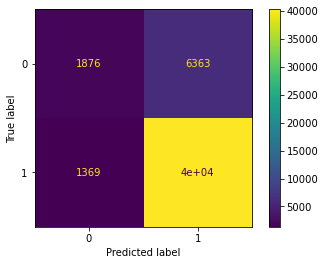

In [105]:
logreg_cm = confusion_matrix(y_test, logreg_preds)
ConfusionMatrixDisplay(logreg_cm).plot();

In [106]:
print(classification_report(y_test, logreg_preds))

              precision    recall  f1-score   support

           0       0.58      0.23      0.33      8239
           1       0.86      0.97      0.91     41596

    accuracy                           0.84     49835
   macro avg       0.72      0.60      0.62     49835
weighted avg       0.82      0.84      0.82     49835



In [100]:
# creating dataframe of coefs
word_coef_df = pd.DataFrame({'coefs': logreg.coef_[0], 'features': tvec.get_feature_names()})
word_coef_df.sort_values(by='coefs',ascending=False,inplace=True)

In [101]:
word_coef_df.head(10)

,coefs,features
62449,5.864779,php
84814,5.319802,widow
33033,4.852676,inr
58663,4.848544,nwtf
62893,4.750692,pkr
79533,4.337173,toilet
41231,4.285676,liberia
82623,4.261581,vahatra
63429,4.182323,portoviejo
62320,4.090632,philippine


In [102]:
word_coef_df.tail(10)

,coefs,features
208,-3.533471,120
69065,-3.578780,rwanda
40588,-3.638456,leader
2091,-3.719618,acb
60402,-3.794685,owned
44058,-3.794803,man
39088,-3.827269,kopsyah
110,-3.878903,100
288,-4.266251,150
61091,-6.105532,parent
